In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.metrics import recall_score, precision_score, roc_auc_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

import numpy as np

from src.utils.io_utils import load_model
from src.utils.logger import logger

### Import validation data

In [3]:
dataset = 'books'

In [4]:
val = pd.read_csv('../data/{}_edges_val.csv'.format(dataset))

In [5]:
val.head()

,product1,product2,edge
0,0076602915,0078908353,1
1,0393920313,1111528128,1
2,0226305023,0231119577,1
3,1465017984,B0017ODENI,1
4,047063751X,1617160857,1


In [6]:
val['edge'].value_counts()

1    8776959
0    8776959
Name: edge, dtype: int64

### Import models

In [7]:
kv = KeyedVectors.load('../model/gensim-w2v-2019-12-04-0934.kv')

### Convert validation data to node IDs

In [8]:
def get_node_id(product_id):
    try:
        return node_dict[product_id]
    except KeyError:
        return '-1'

In [9]:
# val['product1_node_id'] = val['product1'].apply(get_node_id)
# val['product2_node_id'] = val['product2'].apply(get_node_id)

In [10]:
# val['products'] = list(zip(val['product1_node_id'], val['product2_node_id']))

In [11]:
val['products'] = list(zip(val['product1'], val['product2']))

### Get similarity scores

In [12]:
def get_kv_similarity(products):
    try:
        return kv.similarity(products[0], products[1])
    except KeyError:
        return -1
    
get_kv_sim_func = np.vectorize(get_kv_similarity)

In [13]:
%timeit val.head(100)['products'].apply(get_kv_similarity)

2.01 ms ± 72.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%timeit get_kv_sim_func(val.head(100)['products'].values)

2.2 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
val['score'] = get_kv_sim_func(val['products'].values)

In [16]:
val['edge'].value_counts()

1    8776959
0    8776959
Name: edge, dtype: int64

In [17]:
val.head()

,product1,product2,edge,products,score
0,0076602915,0078908353,1,"(0076602915, 0078908353)",0.888863
1,0393920313,1111528128,1,"(0393920313, 1111528128)",0.658904
2,0226305023,0231119577,1,"(0226305023, 0231119577)",0.826310
3,1465017984,B0017ODENI,1,"(1465017984, B0017ODENI)",0.880565
4,047063751X,1617160857,1,"(047063751X, 1617160857)",0.909336


In [18]:
val.tail()

,product1,product2,edge,products,score
17553913,0954243935,0805211500,0,"(0954243935, 0805211500)",0.145048
17553914,184849131X,147780868X,0,"(184849131X, 147780868X)",0.286992
17553915,607310796X,0892872799,0,"(607310796X, 0892872799)",-1.000000
17553916,B00GJZBQA8,0794529186,0,"(B00GJZBQA8, 0794529186)",0.429329
17553917,1585470317,1554810647,0,"(1585470317, 1554810647)",-1.000000


In [19]:
# Set score of unseen item pairs to median score of seen item pairs
val_seen = val[val['score'] != -1]
median_score = np.median(val_seen['score'])
val['score'] = np.where(val['score'] == -1, median_score, val['score'])

### Evaluate results

In [20]:
roc_score = roc_auc_score(val['edge'], val['score'])
logger.info('AUC-ROC: {}'.format(roc_score))

2019-12-05 14:34:22,414 - AUC-ROC: 0.9708673441453924


In [21]:
roc_score_seen = roc_auc_score(val_seen['edge'], val_seen['score'])
logger.info('AUC-ROC: {}'.format(roc_score_seen))

2019-12-05 14:34:28,761 - AUC-ROC: 0.990042688293147


Text(0.5, 1.0, 'Gensim Word2Vec - AUC-ROC: 0.9709')

/Users/eugeneyan/recsys/venv/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/eugeneyan/recsys/venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


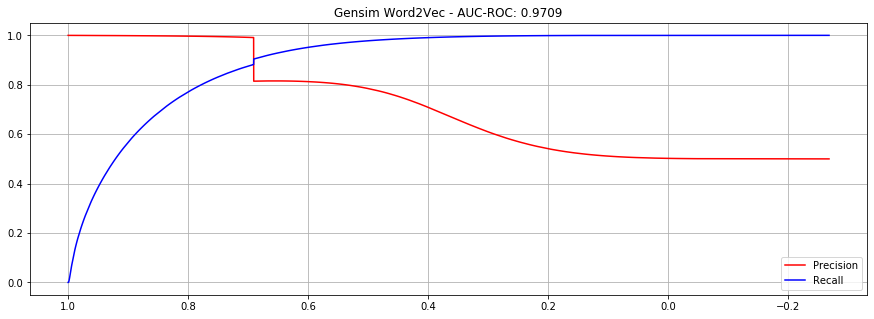

In [22]:
precision, recall, thresholds = precision_recall_curve(val['edge'], val['score'])
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(thresholds, precision[1:], color='r', label='Precision')
plt.plot(thresholds, recall[1:], color='b', label='Recall')
plt.gca().invert_xaxis()
plt.legend()
plt.title('Gensim Word2Vec - AUC-ROC: {:.4f}'.format(roc_score))

Text(0.5, 1.0, 'Gensim Word2Vec (seen items only) - AUC-ROC: 0.9900')

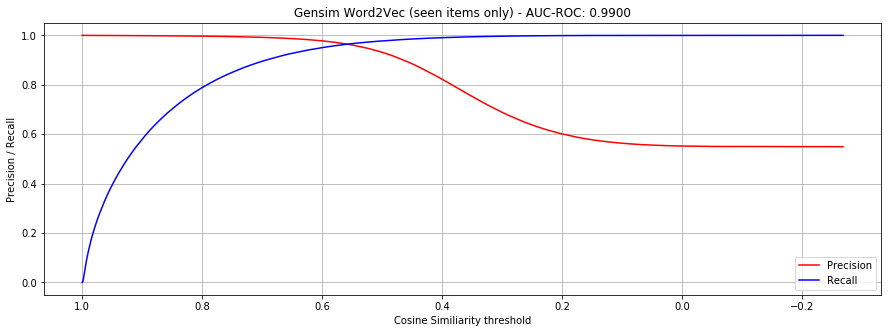

In [23]:
precision, recall, thresholds = precision_recall_curve(val_seen['edge'], val_seen['score'])
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(thresholds, precision[1:], color='r', label='Precision')
plt.plot(thresholds, recall[1:], color='b', label='Recall')
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('Cosine Similiarity threshold')
plt.ylabel('Precision / Recall')
plt.title('Gensim Word2Vec (seen items only) - AUC-ROC: {:.4f}'.format(roc_score_seen))

Text(0.5, 1.0, 'ROC curve')

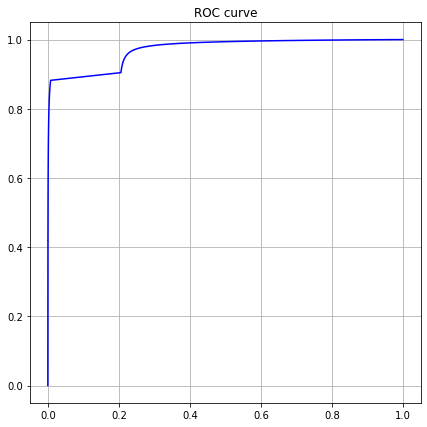

In [24]:
fpr, tpr, roc_thresholds = roc_curve(val['edge'], val['score'])
plt.figure(figsize=(7, 7))
plt.grid()
plt.plot(fpr, tpr, color='b')
plt.title('ROC curve')

Text(0.5, 1.0, 'Precision-Recall Trade-off')

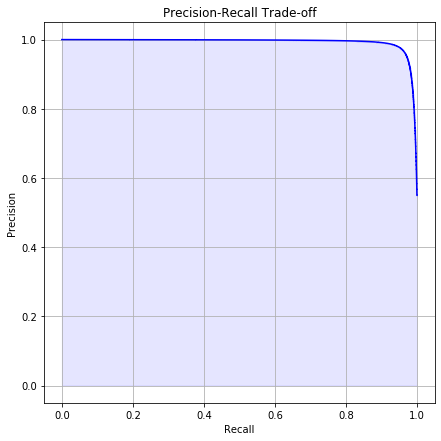

In [25]:
plt.figure(figsize=(7, 7))
plt.grid()
plt.step(recall, precision, color='b', label='Precision-Recall Trade-off')
plt.fill_between(recall, precision, alpha=0.1, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Trade-off')